## Human pose recognition demo

In [1]:
## Include mxnet path: you should include your mxnet local path, if mxnet path is global, 
## you don't need to include it.
import sys
sys.path.append('../../practice_demo')

## import custom model and third party libraries

In [2]:
import cv2 as cv 
import numpy as np
import scipy
import PIL.Image
import math
import time
import matplotlib
%matplotlib inline
import pylab as plt
from GenerateLabelCPM import *
from modelCPM import *

## load model

In [3]:
sym = mxnetModule()

## Load parameters

In [4]:
output_prefix='model/_trained_mpi/realtimePose_mpi'
sym, arg_params, aux_params = mx.model.load_checkpoint(output_prefix, 0)

In [5]:
sym

<Symbol Grouped>

In [6]:
arg_params

{'Mconv1_stage2_L1_bias': <NDArray 128 @cpu(0)>,
 'Mconv1_stage2_L1_weight': <NDArray 128x172x7x7 @cpu(0)>,
 'Mconv1_stage2_L2_bias': <NDArray 128 @cpu(0)>,
 'Mconv1_stage2_L2_weight': <NDArray 128x172x7x7 @cpu(0)>,
 'Mconv1_stage3_L1_bias': <NDArray 128 @cpu(0)>,
 'Mconv1_stage3_L1_weight': <NDArray 128x172x7x7 @cpu(0)>,
 'Mconv1_stage3_L2_bias': <NDArray 128 @cpu(0)>,
 'Mconv1_stage3_L2_weight': <NDArray 128x172x7x7 @cpu(0)>,
 'Mconv1_stage4_L1_bias': <NDArray 128 @cpu(0)>,
 'Mconv1_stage4_L1_weight': <NDArray 128x172x7x7 @cpu(0)>,
 'Mconv1_stage4_L2_bias': <NDArray 128 @cpu(0)>,
 'Mconv1_stage4_L2_weight': <NDArray 128x172x7x7 @cpu(0)>,
 'Mconv1_stage5_L1_bias': <NDArray 128 @cpu(0)>,
 'Mconv1_stage5_L1_weight': <NDArray 128x172x7x7 @cpu(0)>,
 'Mconv1_stage5_L2_bias': <NDArray 128 @cpu(0)>,
 'Mconv1_stage5_L2_weight': <NDArray 128x172x7x7 @cpu(0)>,
 'Mconv1_stage6_L1_bias': <NDArray 128 @cpu(0)>,
 'Mconv1_stage6_L1_weight': <NDArray 128x172x7x7 @cpu(0)>,
 'Mconv1_stage6_L2_bias': <N

## Load test image

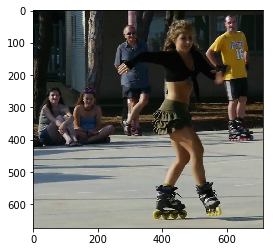

In [7]:
test_image = 'sample_image/ski.jpg'
oriImg = cv.imread(test_image) # B,G,R order
f = plt.imshow(oriImg[:,:,[2,1,0]]) # reorder it before displaying

## set related parameters

In [8]:
model={'boxsize':368}
model['stride'] = 8
param={}
param['scale_search'] = [0.5, 1, 1.5, 2]
multiplier = [x * model['boxsize']*1.0 / oriImg.shape[0] for x in param['scale_search']]

## Add two functions for testing 

In [9]:
def padRightDownCorner(img, stride, padValue):
    h = img.shape[0]
    w = img.shape[1]

    pad = 4 * [None]
    pad[0] = 0 # up
    pad[1] = 0 # left
    pad[2] = 0 if (h%stride==0) else stride - (h % stride) # down
    pad[3] = 0 if (w%stride==0) else stride - (w % stride) # right

    img_padded = img
    pad_up = np.tile(img_padded[0:1,:,:]*0 + padValue, (pad[0], 1, 1))
    img_padded = np.concatenate((pad_up, img_padded), axis=0)
    pad_left = np.tile(img_padded[:,0:1,:]*0 + padValue, (1, pad[1], 1))
    img_padded = np.concatenate((pad_left, img_padded), axis=1)
    pad_down = np.tile(img_padded[-2:-1,:,:]*0 + padValue, (pad[2], 1, 1))
    img_padded = np.concatenate((img_padded, pad_down), axis=0)
    pad_right = np.tile(img_padded[:,-2:-1,:]*0 + padValue, (1, pad[3], 1))
    img_padded = np.concatenate((img_padded, pad_right), axis=1)

    return img_padded, pad

class DataBatch(object):
    def __init__(self, data, label, pad=0):
        self.data = [data]
        self.label = [label]
        self.pad = pad

## define heat and pag map

In [10]:
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 16))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 28))

## Run heatmap  inference algorithm in multi scales 

self._data_shapes:  [DataDesc[data,(1, 3, 184, 200),<type 'numpy.float32'>,NCHW]]
self._label_shapes:  None


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


self._data_shapes:  [DataDesc[data,(1, 3, 368, 392),<type 'numpy.float32'>,NCHW]]
self._label_shapes:  None
self._data_shapes:  [DataDesc[data,(1, 3, 552, 584),<type 'numpy.float32'>,NCHW]]
self._label_shapes:  None
self._data_shapes:  [DataDesc[data,(1, 3, 736, 784),<type 'numpy.float32'>,NCHW]]
self._label_shapes:  None


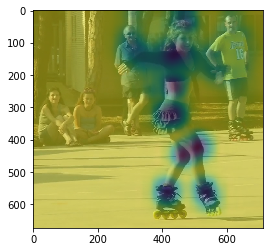

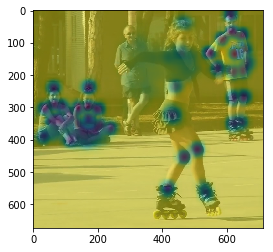

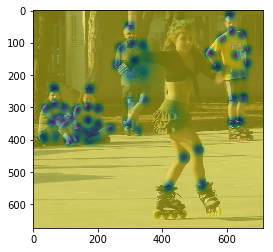

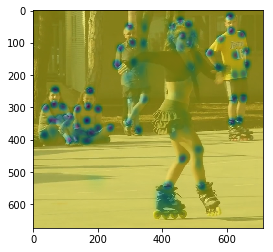

In [11]:
for i in range(len(multiplier)):
    scale = multiplier[i]
    
    imageToTest = cv.resize(oriImg, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_CUBIC)
    imageToTest_padded, pad = padRightDownCorner(imageToTest, 8, 128)

    transposeImage = np.transpose(np.float32(imageToTest_padded[:,:,:]), (2,0,1))/256 - 0.5
    testimage = transposeImage
    cmodel = mx.mod.Module(symbol=sym, label_names=[])
    cmodel.bind(data_shapes=[('data', (1, 3, testimage.shape[1], testimage.shape[2]))])
    cmodel.init_params(arg_params=arg_params, aux_params=aux_params)
    onedata = DataBatch(mx.nd.array([testimage[:,:,:]]), 0)
    
    cmodel.forward(onedata)
    result=cmodel.get_outputs()
    heatmap = np.moveaxis(result[1].asnumpy()[0], 0, -1)

    heatmap = cv.resize(heatmap, (0,0), fx=model['stride'], fy=model['stride'], interpolation=cv.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    heatmap = cv.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv.INTER_CUBIC)
        
    heatmap_avg = heatmap_avg + heatmap / len(multiplier)
    
   
    f = plt.figure(i)
    plt.imshow(oriImg[:,:,[2,1,0]])
    ax2 = plt.imshow(heatmap[:,:,15], alpha=.5)
    f.show()

In [44]:
heatmap_avg>1

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, 

## Show average heatmap of neck

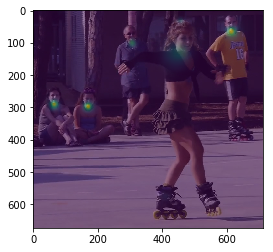

In [45]:
f = plt.figure()
plt.imshow(oriImg[:,:,[2,1,0]])
ax2 = plt.imshow(heatmap_avg[:,:,1], alpha=.5)
f.show()

## Show average heatmap of all human parts

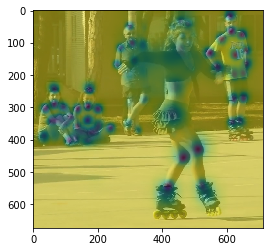

In [46]:
f = plt.figure()
plt.imshow(oriImg[:,:,[2,1,0]])
ax2 = plt.imshow(heatmap_avg[:,:,15], alpha=.5)
f.show()

## Run pag map inference algorithm in multi scales 

self._data_shapes:  [DataDesc[data,(1, 3, 184, 200),<type 'numpy.float32'>,NCHW]]
self._label_shapes:  None
(674, 712, 28)
(674, 712, 28)
self._data_shapes:  [DataDesc[data,(1, 3, 368, 392),<type 'numpy.float32'>,NCHW]]
self._label_shapes:  None
(674, 712, 28)
(674, 712, 28)
self._data_shapes:  [DataDesc[data,(1, 3, 552, 584),<type 'numpy.float32'>,NCHW]]
self._label_shapes:  None
(674, 712, 28)
(674, 712, 28)
self._data_shapes:  [DataDesc[data,(1, 3, 736, 784),<type 'numpy.float32'>,NCHW]]
self._label_shapes:  None
(674, 712, 28)
(674, 712, 28)


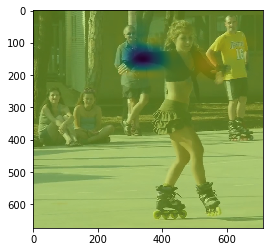

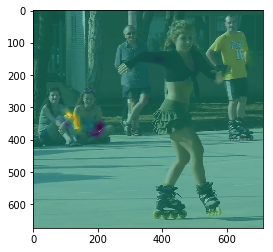

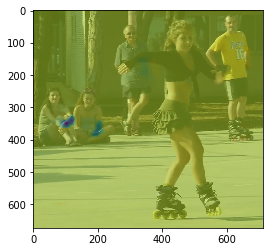

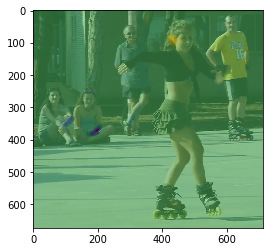

In [47]:
for i in range(len(multiplier)):
    scale = multiplier[i]
    imageToTest = cv.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv.INTER_CUBIC)
    
    imageToTest_padded, pad = padRightDownCorner(imageToTest, 8, 128)
    
    transposeImage = np.transpose(np.float32(imageToTest_padded[:,:,:]), (2,0,1))/256 - 0.5
    #print transposeImage.shape
    testimage = transposeImage
    cmodel = mx.mod.Module(symbol=sym, label_names=[])
    cmodel.bind(data_shapes=[('data', (1,3,
                                   testimage.shape[1],testimage.shape[2]))])
    cmodel.init_params(arg_params=arg_params, aux_params=aux_params)
    onedata = DataBatch(mx.nd.array([testimage[:,:,:]]), 0)
    
    cmodel.forward(onedata)
    result=cmodel.get_outputs()
    
    paf = np.moveaxis(result[0].asnumpy()[0], 0, -1)
    paf = cv.resize(paf, (0,0), fx=model['stride'], fy=model['stride'], interpolation=cv.INTER_CUBIC)
    paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    paf = cv.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv.INTER_CUBIC)
    print paf.shape
        
    paf_avg = paf_avg + paf / len(multiplier)
    
    
    f = plt.figure(i)
    plt.imshow(oriImg[:,:,[2,1,0]])
    plt.imshow(paf[:,:,12], alpha=.5)
    f.show()
    print(paf.shape)

## Show one part

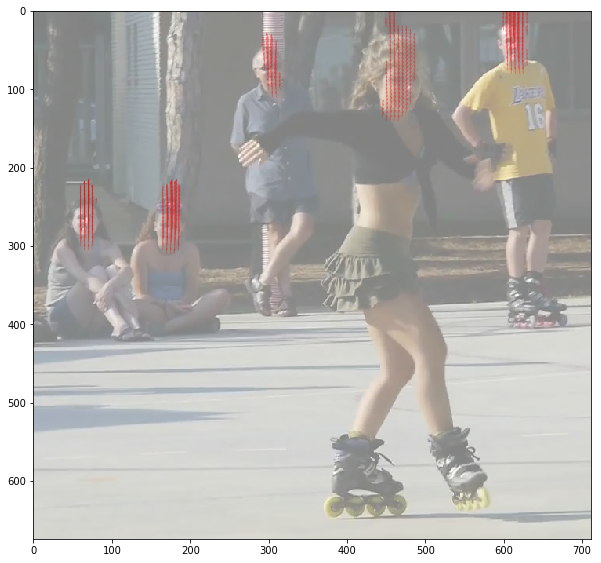

In [48]:
from numpy import ma
U = paf_avg[:,:,0] * -1
V = paf_avg[:,:,1]
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
M = np.zeros(U.shape, dtype='bool')
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

# 1
plt.figure()
plt.imshow(oriImg[:,:,[2,1,0]], alpha = .5)
s = 5
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 10)

## Get human part 

In [49]:
param={}
param['octave'] = 3
param['use_gpu'] = 1
param['starting_range'] = 0.8
param['ending_range'] = 2
param['scale_search'] = [0.5, 1, 1.5, 2]
param['thre1'] = 0.1
param['thre2'] = 0.05
param['thre3'] = 0.5
param['mid_num'] = 4
param['min_num'] = 10
param['crop_ratio'] = 2.5
param['bbox_ratio'] = 0.25
param['GPUdeviceNumber'] = 3

import scipy
print heatmap_avg.shape

#plt.imshow(heatmap_avg[:,:,2])
from scipy.ndimage.filters import gaussian_filter
all_peaks = []
peak_counter = 0

for part in range(17-1):
    x_list = []
    y_list = []
    map_ori = heatmap_avg[:,:,part]
    map = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param['thre1']))
    peaks = zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

(674, 712, 16)


In [50]:
## all_peaks
## (x, y, score, id)

In [51]:
len(all_peaks)

16

In [52]:
len(all_peaks[15])

157

In [53]:
for i in all_peaks:
    if(len(i)>10):
        print i

[(77, 0, 1.0023070275783539, 81), (106, 0, 1.0023463368415833, 82), (555, 0, 0.99501961469650269, 83), (697, 0, 0.99958689510822296, 84), (382, 5, 0.98086220026016235, 85), (128, 12, 1.0024107396602631, 86), (145, 13, 1.0024416148662567, 87), (10, 18, 0.99991478025913239, 88), (74, 18, 1.002417653799057, 89), (64, 38, 1.0024116039276123, 90), (379, 38, 0.98413105309009552, 91), (20, 40, 1.0003482401371002, 92), (146, 41, 1.0019570291042328, 93), (443, 72, 0.89587360620498657, 94), (17, 77, 1.0019972920417786, 95), (481, 78, 0.87131421267986298, 96), (68, 82, 1.0019874274730682, 97), (107, 83, 1.0017760097980499, 98), (151, 87, 1.0018030405044556, 99), (617, 102, 0.94377803802490234, 100), (568, 112, 0.89587797224521637, 101), (711, 127, 0.99013322591781616, 102), (587, 131, 0.94765931367874146, 103), (648, 147, 0.82110440731048584, 104), (647, 148, 0.82084998488426208, 105), (144, 154, 1.0021200478076935, 106), (32, 156, 1.0011211633682251, 107), (132, 156, 1.0021052062511444, 108), (6

## Link human parts

In [77]:
# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[1, 2], [2, 3], [3, 4], [4, 5], [2, 6], [6, 7], [7, 8], [2, 15], [15, 12],
           [12, 13], [13, 14], [15, 9], [9, 10], [10, 11]]
# the middle joints heatmap correpondence
mapIdx = [[16, 17], [18, 19], [20, 21], [22, 23],
          [24, 25], [26, 27], [28, 29], [30, 31], 
          [38, 39], [40, 41], [42, 43], [32, 33],
          [34, 35], [36, 37]];

In [86]:
connection_all = []
special_k = []
special_non_zero_index = []
mid_num = 11

for k in range(len(mapIdx)):
    score_mid = paf_avg[:,:,[x-16 for x in mapIdx[k]]]
    candA = all_peaks[limbSeq[k][0]-1]
    candB = all_peaks[limbSeq[k][1]-1]
    print(k)
    print(candA)
    print('---------')
    print(candB)
    nA = len(candA)
    nB = len(candB)
    indexA, indexB = limbSeq[k]
    if(nA != 0 and nB != 0):
        connection_candidate = []
        for i in range(nA):
            for j in range(nB):
                vec = np.subtract(candB[j][:2], candA[i][:2])
                # print('vec: ',vec)
                norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                # print('norm: ', norm)
                vec = np.divide(vec, norm)
                # print('normalized vec: ', vec)
                startend = zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                               np.linspace(candA[i][1], candB[j][1], num=mid_num))
                # print('startend: ', startend)
                vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                  for I in range(len(startend))])
                # print('vec_x: ', vec_x)
                vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                  for I in range(len(startend))])
                # print('vec_y: ', vec_y)
                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                # print(score_midpts)
                # print('score_midpts: ', score_midpts)
                score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                
                print('score_with_dist_prior: ', score_with_dist_prior)
                criterion1 = len(np.nonzero(score_midpts > param['thre2'])[0]) > 0.8 * len(score_midpts)
                # print('score_midpts > param["thre2"]: ', len(np.nonzero(score_midpts > param['thre2'])[0]))
                criterion2 = score_with_dist_prior > 0
                
                if criterion1 and criterion2:
                    # print('match')
                    # print(i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2])
                    connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])
                # print('--------end-----------')
        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
        # print('-------------connection_candidate---------------')
        # print(connection_candidate)
        # print('------------------------------------------------')
        connection = np.zeros((0,5))
        for c in range(len(connection_candidate)):
            i,j,s = connection_candidate[c][0:3]
            if(i not in connection[:,3] and j not in connection[:,4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                # print('----------connection-----------')
                # print(connection)
                # print('-------------------------------')
                if(len(connection) >= min(nA, nB)):
                    break

        connection_all.append(connection)
    elif(nA != 0 or nB != 0):
        special_k.append(k)
        special_non_zero_index.append(indexA if nA != 0 else indexB)
        connection_all.append([])

0
[(460, 0, 0.14988705534779001, 0), (610, 17, 0.659239761531353, 1), (467, 37, 0.27453682204941288, 2), (299, 49, 0.40383635023317765, 3), (66, 243, 0.57397522666724399, 4), (175, 245, 0.57782126723213878, 5)]
---------
[(456, 32, 0.1828262819617521, 6), (614, 65, 0.71429424732923508, 7), (307, 102, 0.40177955504623242, 8), (454, 131, 0.28319564810954034, 9), (65, 291, 0.64820071717258543, 10), (170, 298, 0.69967172598444449, 11)]
('score_with_dist_prior: ', 0.7730388275151675)
('score_with_dist_prior: ', 0.15149044600078915)
('score_with_dist_prior: ', 0.094387020269174615)
('score_with_dist_prior: ', 0.74373967324259249)
('score_with_dist_prior: ', -0.15736825740560015)
('score_with_dist_prior: ', 0.00089028543747371458)
('score_with_dist_prior: ', 0.043250407735195846)
('score_with_dist_prior: ', 2.53807072260794)
('score_with_dist_prior: ', 0.10543719745050519)
('score_with_dist_prior: ', 0.26505297910863945)
('score_with_dist_prior: ', -0.17500369775673841)
('score_with_dist_prio

12
[(485, 102, 0.11422399260482052, 42), (623, 198, 0.47827973961830139, 43), (299, 200, 0.16240021295379847, 44), (434, 323, 0.39017499168403447, 45), (154, 374, 0.41186747648316668, 46), (34, 389, 0.45202666325349128, 47)]
---------
[(621, 274, 0.55220095999538898, 48), (300, 285, 0.1690662537002936, 49), (82, 337, 0.51987351237039547, 50), (140, 377, 0.22928293271979783, 51), (141, 378, 0.22953927722119261, 52), (511, 430, 0.65640971809625626, 53)]
('score_with_dist_prior: ', 0.25347025916616056)
('score_with_dist_prior: ', 0.080266238385119704)
('score_with_dist_prior: ', -0.39677144035798129)
('score_with_dist_prior: ', -0.10595781128007886)
('score_with_dist_prior: ', -0.10131250865693098)
('score_with_dist_prior: ', 0.29014527951869362)
('score_with_dist_prior: ', 1.9037994143898169)
('score_with_dist_prior: ', 0.064335643215623461)
('score_with_dist_prior: ', -0.43503052845245221)
('score_with_dist_prior: ', -0.1772905017580727)
('score_with_dist_prior: ', -0.17237052654765991)

In [87]:
connection_all

[array([[  1.        ,   7.        ,   2.53807072,   1.        ,   1.        ],
        [  5.        ,  11.        ,   2.30605728,   5.        ,   5.        ],
        [  4.        ,  10.        ,   2.13118464,   4.        ,   4.        ],
        [  3.        ,   8.        ,   1.48952317,   3.        ,   2.        ],
        [  2.        ,   9.        ,   0.80436218,   2.        ,   3.        ],
        [  0.        ,   6.        ,   0.77303883,   0.        ,   0.        ]]),
 array([[ 11.        ,  17.        ,   2.18153995,   5.        ,   5.        ],
        [  7.        ,  13.        ,   2.06987533,   1.        ,   1.        ],
        [ 10.        ,  16.        ,   1.97236035,   4.        ,   4.        ],
        [  8.        ,  14.        ,   1.2419557 ,   2.        ,   2.        ],
        [  6.        ,  12.        ,   0.53945346,   0.        ,   0.        ],
        [  9.        ,  15.        ,   0.45022393,   3.        ,   3.        ]]),
 array([[ 16.        ,  21.        ,

In [88]:
# connection_all
# pos1, pos2, score, i, j

## Human part connection 

In [89]:
# last number in each row is the total parts number of that person
# the second last number in each row is the score of the overall configuration
subset = -1 * np.ones((0, 20))

candidate = np.array([item for sublist in all_peaks for item in sublist])

candidate

array([[  4.60000000e+02,   0.00000000e+00,   1.49887055e-01,
          0.00000000e+00],
       [  6.10000000e+02,   1.70000000e+01,   6.59239762e-01,
          1.00000000e+00],
       [  4.67000000e+02,   3.70000000e+01,   2.74536822e-01,
          2.00000000e+00],
       [  2.99000000e+02,   4.90000000e+01,   4.03836350e-01,
          3.00000000e+00],
       [  6.60000000e+01,   2.43000000e+02,   5.73975227e-01,
          4.00000000e+00],
       [  1.75000000e+02,   2.45000000e+02,   5.77821267e-01,
          5.00000000e+00],
       [  4.56000000e+02,   3.20000000e+01,   1.82826282e-01,
          6.00000000e+00],
       [  6.14000000e+02,   6.50000000e+01,   7.14294247e-01,
          7.00000000e+00],
       [  3.07000000e+02,   1.02000000e+02,   4.01779555e-01,
          8.00000000e+00],
       [  4.54000000e+02,   1.31000000e+02,   2.83195648e-01,
          9.00000000e+00],
       [  6.50000000e+01,   2.91000000e+02,   6.48200717e-01,
          1.00000000e+01],
       [  1.70000000e

In [90]:
for k in range(len(mapIdx)):
    if k not in special_k:
        partAs = connection_all[k][:,0]
        partBs = connection_all[k][:,1]
        indexA, indexB = np.array(limbSeq[k]) - 1

        for i in range(len(connection_all[k])): #= 1:size(temp,1)
            found = 0
            subset_idx = [-1, -1]
            for j in range(len(subset)): #1:size(subset,1):
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1
            
            if found == 1:
                j = subset_idx[0]
                if(subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
            elif found == 2: # if found 2 and disjoint, merge them
                j1, j2 = subset_idx
                print "found = 2"
                membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                if len(np.nonzero(membership == 2)[0]) == 0: #merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1)
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                else: # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

            # if find no partA in the subset, create a new subset
            elif not found and k < 17:
                row = -1 * np.ones(20)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                subset = np.vstack([subset, row])

# delete some rows of subset which has few parts occur
deleteIdx = [];
for i in range(len(subset)):
    if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
        deleteIdx.append(i)
subset = np.delete(subset, deleteIdx, axis=0)

In [91]:
subset

array([[  1.        ,   7.        ,  13.        ,  19.        ,
         24.        ,  29.        ,  34.        ,  39.        ,
         43.        ,  48.        ,  54.        ,  61.        ,
         65.        ,  70.        ,  76.        ,  -1.        ,
         -1.        ,  -1.        ,  39.19209507,  15.        ],
       [  5.        ,  11.        ,  17.        ,  22.        ,
         27.        ,  33.        ,  37.        ,  41.        ,
         46.        ,  51.        ,  -1.        ,  63.        ,
         68.        ,  73.        ,  79.        ,  -1.        ,
         -1.        ,  -1.        ,  31.77278503,  14.        ],
       [  4.        ,  10.        ,  16.        ,  21.        ,
         26.        ,  32.        ,  36.        ,  40.        ,
         47.        ,  50.        ,  58.        ,  64.        ,
         67.        ,  72.        ,  80.        ,  -1.        ,
         -1.        ,  -1.        ,  32.96728442,  15.        ],
       [  3.        ,   8.        ,  

## Show human part keypoint

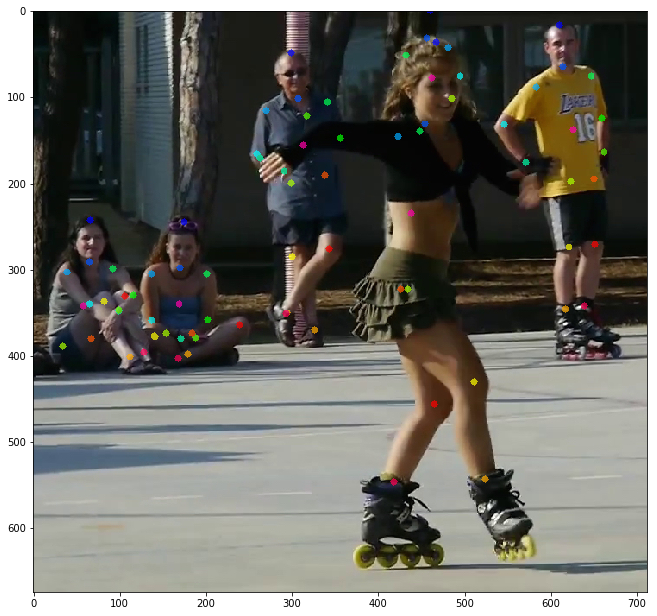

In [92]:
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]

cmap = matplotlib.cm.get_cmap('hsv')

canvas = cv.imread(test_image) # B,G,R order

for i in range(15):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        cv.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

to_plot = cv.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(11, 11)

## Show human part connection

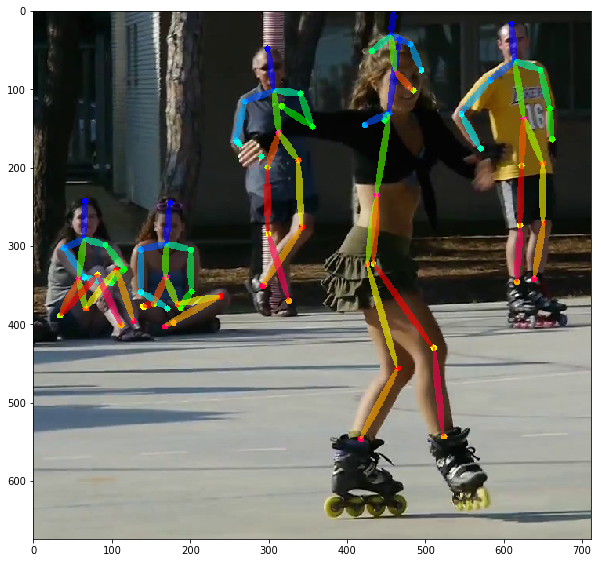

In [93]:
# visualize 2
stickwidth = 4

for i in range(14):
    for n in range(len(subset)):
        index = subset[n][np.array(limbSeq[i])-1]
        if -1 in index:
            continue
        cur_canvas = canvas.copy()
        Y = candidate[index.astype(int), 0]
        X = candidate[index.astype(int), 1]
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        cv.fillConvexPoly(cur_canvas, polygon, colors[i])
        canvas = cv.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
        
plt.imshow(canvas[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 10)